In [1]:
import os
import cv2
import glob
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
image_path = '/external_drive/BUS_Deep_Learning/data/Dataset_BUSI_with_GT/malignant/malignant (123).png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [4]:
#CLAHE
clahe = cv2.createCLAHE()
clahe_img = clahe.apply(img)

In [5]:
res = np.hstack((img,clahe_img))

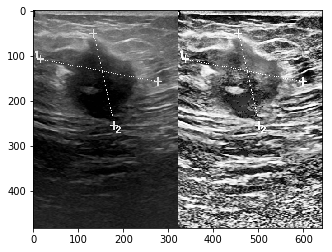

In [6]:
plt.imshow(res,cmap='gray')

In [7]:
#Hist Equalization
eq_img = cv2.equalizeHist(img)

In [8]:
res = np.hstack((img,eq_img))

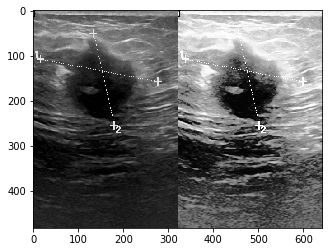

In [9]:
plt.imshow(res,cmap='gray')

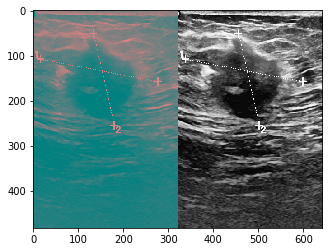

In [19]:
#LAB
#Convert image to LAB Color model
lab= cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
lab= cv2.cvtColor(lab, cv2.COLOR_BGR2LAB)

#Splitting the LAB image to different channels
l, a, b = cv2.split(lab)

#Applying CLAHE to L-channel
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)

#Merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

#Converting image from LAB Color model to RGB model
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
plt.imshow(np.hstack((lab,final)))

**DESCRIPTIVE STATISTICS**

**TEST IMAGES**

In [ ]:
path_to_bus = '/external_drive/BUS_Deep_Learning/data/test_images/STU-Hospital/Hospital'

In [ ]:
path_to_test_imgs = '/external_drive/BUS_Deep_Learning/data/seg_dir_test_images'
path_to_test_masks = '/external_drive/BUS_Deep_Learning/data/seg_dir_test_masks'
os.makedirs(path_to_test_imgs,exist_ok=True)
os.makedirs(path_to_test_masks,exist_ok=True)

In [ ]:
#Create directory for test images
for img in os.listdir(path_to_bus):
    if 'Test' in img:
        shutil.copy(os.path.join(path_to_bus,img),path_to_test_imgs)
    if 'mask' in img:
        shutil.copy(os.path.join(path_to_bus,img),path_to_test_masks)
        os.rename(os.path.join(path_to_test_masks,img), os.path.join(path_to_test_masks,img.replace('mask','Test_Image')))

**TRAINING/VAL IMAGES**

In [ ]:
path_to_bus = '/external_drive/BUS_Deep_Learning/data/Dataset_BUSI_with_GT'

In [ ]:
#Create dataframe for train/val images
image_path = []
images = []
masks = []
lesion_state = []
for condition in os.listdir(path_to_bus):
    for bus in os.listdir(os.path.join(path_to_bus,condition)):
        if 'mask' in bus:
            masks.append(bus)
        else:
            image_path.append(os.path.join(path_to_bus,condition,bus))
            images.append(bus)
            lesion_state.append(condition)

In [ ]:
fmatrix = pd.DataFrame(columns=['image_path','images','lesion_state'])
fmatrix['image_path'] = image_path
fmatrix['images'] = images
fmatrix['lesion_state'] = lesion_state

In [ ]:
fmatrix['lesion_state'].value_counts()

In [ ]:
#Run to exclude all normals (no lesion)
fmatrix = fmatrix.loc[fmatrix['lesion_state']!='normal'].sample(frac=1)

In [ ]:
fmatrix.head()

In [ ]:
train_set, val_set = train_test_split(fmatrix, test_size=0.2, stratify=fmatrix['lesion_state'], random_state=9)
train_set['lesion_state_one_hot'] = pd.get_dummies(train_set['lesion_state']).values.tolist()
val_set['lesion_state_one_hot'] = pd.get_dummies(val_set['lesion_state']).values.tolist()

In [ ]:
train_set['lesion_state'].value_counts()

In [ ]:
val_set['lesion_state'].value_counts()

In [ ]:
train_set.to_pickle('/external_drive/BUS_Deep_Learning/train_set_class_nn.pickle')
val_set.to_pickle('/external_drive/BUS_Deep_Learning/val_set_class_nn.pickle')

In [ ]:
#Create directories for train/val images
path_to_train_images = '/external_drive/BUS_Deep_Learning/data/seg_dir_instance_seg_nn/train_images'
path_to_val_images = '/external_drive/BUS_Deep_Learning/data/seg_dir_instance_seg_nn/val_images'
os.makedirs(path_to_train_images,exist_ok=True)
os.makedirs(path_to_val_images,exist_ok=True)

path_to_train_masks = '/external_drive/BUS_Deep_Learning/data/seg_dir_instance_seg_nn/train_masks'
path_to_val_masks = '/external_drive/BUS_Deep_Learning/data/seg_dir_instance_seg_nn/val_masks'
os.makedirs(path_to_train_masks,exist_ok=True)
os.makedirs(path_to_val_masks,exist_ok=True)

**CREATE DIR FOR TRAINING MASK R-CNN**

In [ ]:
for condition in os.listdir(path_to_bus):
    for bus in os.listdir(os.path.join(path_to_bus,condition)):
        if 'mask' in bus:
            if bus.split('_')[0]+'.png' in train_set['images'].values:
                shutil.copy(os.path.join(path_to_bus,condition,bus),os.path.join(path_to_train_masks,bus))
            elif bus.split('_')[0]+'.png' in val_set['images'].values:
                shutil.copy(os.path.join(path_to_bus,condition,bus),os.path.join(path_to_val_masks,bus))
        else:
            if bus in train_set['images'].values:
                shutil.copy(os.path.join(path_to_bus,condition,bus),os.path.join(path_to_train_images,bus))
            elif bus in val_set['images'].values:
                shutil.copy(os.path.join(path_to_bus,condition,bus),os.path.join(path_to_val_images,bus))

**CREATE DIR FOR TRAINING U-NET**

In [ ]:
def merge_masks(arr):
    if np.any(arr!=0.0):
        return 255.0
    else:
        return 0.0

#Train Set
print('Train Set')
for idx, row in train_set.iterrows():
    path_to_image = os.path.join(path_to_bus,row['lesion_state'],row['images'])
    print(path_to_image)
    shutil.copy(path_to_image,os.path.join(path_to_train_images,row['images']))
    path_to_masks = glob.glob(path_to_image.replace('.png','_mask*'))
    print('number of masks-->',len(path_to_masks))
    masks = []
    for path_to_mask in path_to_masks:
        masks.append(cv2.imread(path_to_mask, cv2.IMREAD_GRAYSCALE))
    masks = np.array(masks)
    mask = np.apply_along_axis(merge_masks, 0, masks)
    cv2.imwrite(os.path.join(path_to_train_masks,row['images']),mask)

print('')

#Validation Set    
print('Val Set')
for idx, row in val_set.iterrows():
    path_to_image = os.path.join(path_to_bus,row['lesion_state'],row['images'])
    print(path_to_image)
    shutil.copy(path_to_image,os.path.join(path_to_val_images,row['images']))
    path_to_masks = glob.glob(path_to_image.replace('.png','_mask*'))
    print('number of masks-->',len(path_to_masks))
    masks = []
    for path_to_mask in path_to_masks:
        masks.append(cv2.imread(path_to_mask, cv2.IMREAD_GRAYSCALE))
    masks = np.array(masks)
    mask = np.apply_along_axis(merge_masks, 0, masks)
    cv2.imwrite(os.path.join(path_to_val_masks,row['images']),mask)